In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import os
from scipy.interpolate import griddata

# NEK5000 Python libraries
import pymech
from pymech.neksuite import readnek
from pymech.vtksuite import exa2vtk
import pymech.dataset

### Mesh generation
This cell generates the points for the mesh given the right input parameters.

In [105]:
def mesh_transform(points, method='tanh_lower', k=1):
    ''' Applies a geometric mesh transformation to increase resolution at desired locations. 
    
    Inputs:
    - y (list of floats or array): points to be transformed
    - k (int): 'sharpness' factor
    
    Outputs:
    - arr_y_mod (list of floats): transformed points
    
    '''
    
    # Get number of points
    n = len(points)
    # Get extrema of array points
    ll, ul = min(points), max(points)
    # Start with base domain of 0 to 1
    base = np.linspace(0, 1, n)
    # Define array that represents true coordinates
    arr = np.linspace(ll, ul, n)
    
    # Get transformed array using a function. This can be modified.
    if method == 'tanh_lower':
        arr_mod = sorted([(np.tanh(k*np.pi*(point-0.5)) + 1)/(2/(ul-ll)) + ll for point in base])
    elif method =='tanh_upper':
        arr_mod = sorted([round((ul-ll)*(np.tanh(0.75*np.pi*(point-1)) + 1) + ll, 3) for point in base])
        
    # Catch any point discrepancies at extrema
    arr_mod[0] = ll
    arr_mod[-1] = ul
    arr_mod = [round(value, 3) for value in arr_mod]
        
    return arr_mod

In [106]:
def mesh_generator(num_of_bldg, domain_height, bldg_width, bldg_height, nelx, nely, case):
    # Upwind fetch
    upwind_fetch = 3
    # Downwind fetch
    downwind_fetch = 10
    # Domain extent
    extent = [upwind_fetch + num_of_bldg*(bldg_width + bldg_spacing) + downwind_fetch,
             domain_height]
    # Domains
    domains = []
    # Boolean to include solid domain
    solids = False

    # y-coordinates
    lower_y = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50]
    upper_y = [0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]

    # Filename
    filename = '/Users/gabriel/Nek5000/run/int_bdy/{0}.box'.format(case)
    f = open(filename, 'w')

    f.write('ray_9.rea\n2\n2\n')

    f.write('# =====================================\n')

    for n in range(0, num_of_bldg+1):
        # Define inflow domain
        if n == 0:
            # Lower left box
            x = [round(el, 2) for el in np.linspace(upwind_fetch, upwind_fetch + bldg_spacing, nelx)]
            y = [round(el, 2) for el in np.linspace(0, bldg_height, nely)]
            x = mesh_transform(x)
            y_lower = mesh_transform(y)
            X, Y = np.meshgrid(x, y_lower)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(nelx-1, nely-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y_lower))) + '\n') # Write y-points
            f.write('E  ,W  ,W  ,E  \n') # Write velocity BCs
            f.write('E  ,I  ,f  ,E  \n') # Write thermal BCs
            # Upper left box
            x = [round(el, 2) for el in np.linspace(upwind_fetch, upwind_fetch + bldg_spacing, nelx)]
            y = [round(el, 2) for el in np.linspace(bldg_height, domain_height, nely)]
            x = mesh_transform(x)
            y_upper = mesh_transform(y, method='tanh_upper')
            X, Y = np.meshgrid(x, y_upper)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(nelx-1, nely-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y_upper))) + '\n') # Write y-points
            f.write('E  ,E  ,E  ,SYM\n') # Write velocity BCs
            f.write('E  ,E  ,E  ,SYM\n') # Write thermal BCs
            # Inlet domain
            x = [round(el, 2) for el in np.linspace(0, upwind_fetch, nelx)]
            y = sorted(list(set(y_lower + y_upper)))
            X, Y = np.meshgrid(x, y)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(len(x)-1,len(y)-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
            f.write('v  ,E  ,W  ,SYM\n') # Write velocity BCs
            f.write('t  ,E  ,f  ,SYM\n') # Write thermal BCs
            # Upper right box
            x = [round(el, 2) for el in np.linspace(upwind_fetch + bldg_spacing, 
                                                    upwind_fetch + bldg_spacing + bldg_width, 
                                                    nelx)]
            y = [round(el, 2) for el in np.linspace(bldg_height, domain_height, nely)]
            #x = mesh_transform(x)
            y = mesh_transform(y, method='tanh_upper')
            X, Y = np.meshgrid(x, y)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(len(x)-1, nely-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
            f.write('E  ,E  ,W  ,SYM\n') # Write velocity BCs
            f.write('E  ,E  ,f  ,SYM\n') # Write thermal BCs
            # Lower solid right box
            if solids:
                x = [round(el, 2) for el in np.linspace(upwind_fetch + bldg_spacing, 
                                                        upwind_fetch + bldg_spacing + bldg_width, 
                                                        nelx)]
                y = [round(el, 2) for el in np.linspace(0, bldg_height, nely)]
                X, Y = np.meshgrid(x, y)
                domains.append([X, Y])
                f.write('Box \n')
                f.write('{0} {1} \n'.format(nelx-1, nely-1))  # Write number of elements
                f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
                f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
                f.write('W  ,W  ,W  ,W  \n') # Write velocity BCs
                f.write('I  ,I  ,I  ,f  \n') # Write thermal BCs
        elif n != num_of_bldg:
            # Lower left box
            x = [round(el, 2) for el in np.linspace(upwind_fetch + n*(bldg_width + bldg_spacing), 
                            upwind_fetch + n*(bldg_width + bldg_spacing) + bldg_spacing, 
                            nelx)]
            x = mesh_transform(y)
            y = [round(el, 2) for el in np.linspace(0, bldg_height, nely)]
            y = mesh_transform(y)
            X, Y = np.meshgrid(x, y)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(nelx-1, nely-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
            f.write('W  ,W  ,W  ,E  \n') # Write velocity BCs
            f.write('I  ,I  ,f  ,E  \n') # Write thermal BCs
            # Upper left box
            x = [round(el, 2) for el in np.linspace(upwind_fetch + n*(bldg_width + bldg_spacing), 
                            upwind_fetch + n*(bldg_width + bldg_spacing) + bldg_spacing, 
                            nelx)]
            y = [round(el, 2) for el in np.linspace(bldg_height, domain_height, nely)]
            y = mesh_transform(y, method='tanh_upper')
            X, Y = np.meshgrid(x, y)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(nelx-1, nely-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
            f.write('E  ,E  ,E  ,SYM\n') # Write velocity BCs
            f.write('E  ,E  ,E  ,SYM\n') # Write thermal BCs
            # Upper right box
            x = [round(el, 2) for el in np.linspace(upwind_fetch + n*(bldg_width + bldg_spacing) + bldg_spacing, 
                            upwind_fetch + (n+1)*(bldg_width + bldg_spacing), 
                            nelx)]
            y = [round(el, 2) for el in np.linspace(bldg_height, domain_height, nely)]
            y = mesh_transform(y, method='tanh_upper')
            X, Y = np.meshgrid(x, y)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(len(x)-1, nely-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
            f.write('E  ,E  ,W  ,SYM\n') # Write velocity BCs
            f.write('E  ,E  ,f  ,SYM\n') # Write thermal BCs
            # Lower solid right box
            if solids:
                x = [round(el, 2) for el in np.linspace(upwind_fetch + n*(bldg_width + bldg_spacing) + bldg_spacing, 
                                upwind_fetch + (n+1)*(bldg_width + bldg_spacing), 
                                nelx)]
                y = [round(el, 2) for el in np.linspace(0, bldg_height, nely)]
                X, Y = np.meshgrid(x, y)
                domains.append([X, Y])
                f.write('Box \n')
                f.write('{0} {1} \n'.format(nelx-1, nely-1))  # Write number of elements
                f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
                f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
                f.write('W  ,W  ,W  ,W  \n') # Write velocity BCs
                f.write('I  ,I  ,I  ,f  \n') # Write thermal BCs
        else:
            # Outlet domain, lower
            x = [round(el, 2) for el in np.linspace(upwind_fetch + n*(bldg_width + bldg_spacing), 
                            upwind_fetch + n*(bldg_width + bldg_spacing) + downwind_fetch, 
                            nelx*2)]
            y = y_lower
            X, Y = np.meshgrid(x, y)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(len(x)-1, nely-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
            f.write('W  ,O  ,W  ,E  \n') # Write velocity BCs
            f.write('I  ,O  ,f  ,E  \n') # Write thermal BCs
            # Outlet domain, upper
            x = [round(el, 2) for el in np.linspace(upwind_fetch + n*(bldg_width + bldg_spacing), 
                            upwind_fetch + n*(bldg_width + bldg_spacing) + downwind_fetch, 
                            nelx*2)]
            y = y_upper
            X, Y = np.meshgrid(x, y)
            domains.append([X, Y])
            f.write('Box \n')
            f.write('{0} {1} \n'.format(len(x)-1, nely-1))  # Write number of elements
            f.write(' '.join(map(str, list(x))) + '\n') # Write x-points
            f.write(' '.join(map(str, list(y))) + '\n') # Write y-points
            f.write('E  ,O  ,E  ,SYM\n') # Write velocity BCs
            f.write('E  ,O  ,E  ,SYM\n') # Write thermal BCs
    f.close()
    
    # Plot the mesh
    fig, ax = plt.subplots(dpi=144)
    for domain in domains:
        ax.scatter(domain[0], domain[1], s=1)
    ax.set_xlim([0, extent[0]])
    ax.set_ylim([0, extent[1]])
    ax.set_aspect('equal')

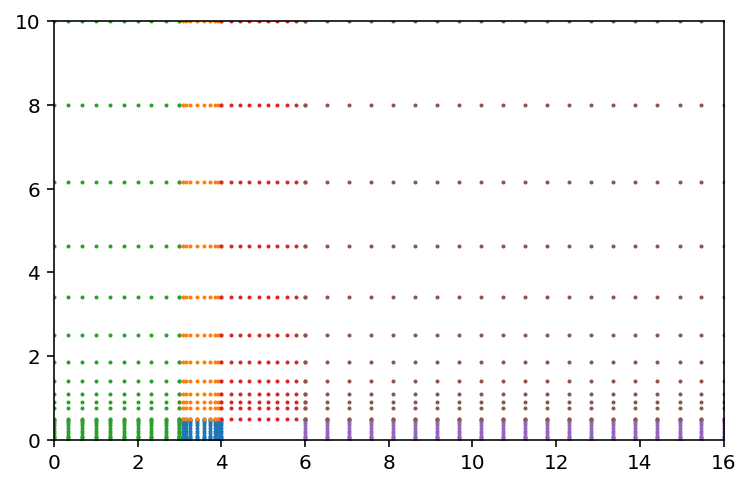

In [110]:
# Number of buildings
num_of_bldg = 1
# Height of fluid domain
domain_height = 10
# Width of buildings
bldg_width = 2
# Height of buildings
bldg_height = 0.5
# Inter-building spacing
bldg_spacing = 1
# Number of elements, x
nelx = 10
# Number of elements, y, for lower domain
nely = 12
# Number of elements, y, for upper domain
# nely_upper = 10
# Case name
case_name = 'set_1-1_bldg'

mesh_generator(num_of_bldg, domain_height, bldg_width, bldg_height, nelx, nely, case_name)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[1.746, 2.039, 2.439, 2.974, 3.675, 4.571, 5.676, 6.98, 8.445, 10.0]


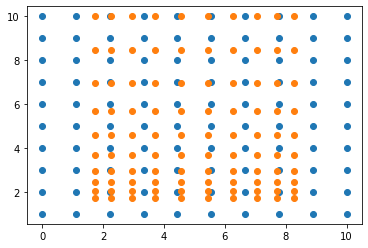

In [101]:
n = 10
k = 0.5
ll_x, ul_x = 0, 10
ll_y, ul_y = 1, 10
base_y = np.linspace(0, 1, n)
arr_x = np.linspace(ll_x, ul_x, n)
arr_y = np.linspace(ll_y, ul_y, n)
arr_x_mod = [round((np.tanh(k*np.pi*(y_val-0.5)) + 1)/(2/(ul_x-ll_x)), 3) + ll_x for y_val in base_y]
arr_y_mod = [round((ul_y-ll_y)*(np.tanh(k*np.pi*(y_val-1)) + 1) + ll_y, 3) + ll_x for y_val in base_y]

print(arr_y)
print(arr_y_mod)

X, Y = np.meshgrid(arr_x, arr_y)
X_mod, Y_mod = np.meshgrid(arr_x_mod, arr_y_mod)
plt.scatter(X, Y)
plt.scatter(X_mod, Y_mod)
ax.set_aspect('equal')

[-1.         -0.68421053 -0.36842105 -0.05263158  0.26315789  0.57894737
  0.89473684  1.21052632  1.52631579  1.84210526  2.15789474  2.47368421
  2.78947368  3.10526316  3.42105263  3.73684211  4.05263158  4.36842105
  4.68421053  5.        ]
[-1.0, -0.999, -0.996, -0.991, -0.974, -0.9319999999999999, -0.819, -0.536, 0.10499999999999998, 1.271, 2.729, 3.8949999999999996, 4.536, 4.819, 4.932, 4.974, 4.991, 4.996, 4.999, 5.0]


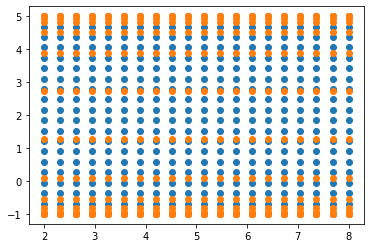

In [96]:
n = 20
k = 3
ll_x, ul_x = 2, 8
ll_y, ul_y = -1, 5
base_y = np.linspace(0, 1, n)
arr_x = np.linspace(ll_x, ul_x, n)
arr_y = np.linspace(ll_y, ul_y, n)
arr_x_mod = [round((np.tanh(k*np.pi*(y_val-0.5)) + 1)/(2/(ul_x-ll_x)), 3) + ll_x for y_val in base_y]
arr_y_mod = [round(((np.tanh(k*np.pi*(y_val-0.5)) + 1)/(2/(ul_y-ll_y))), 3) + ll_y for y_val in base_y]

print(arr_y)
print(arr_y_mod)

X, Y = np.meshgrid(arr_x, arr_y)
X_mod, Y_mod = np.meshgrid(arr_x, arr_y_mod)
plt.scatter(X, Y)
plt.scatter(X_mod, Y_mod)
ax.set_aspect('equal')

### Non-rectilinear data

#### Load data

In [112]:
def load_data_nonrectilinear(project, dirname='/Users/gabriel/Nek5000/run'):
    # Define directory name
    dirname = '/Users/gabriel/Nek5000/run/{0}'.format(project)
    # Trial file
    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if '.f0' in file]
    # Read dataset into a list
    fields = [readnek(file) for file in files]
    # Generate list of exadata structures sorted by time
    ds = exa_timesort(fields)
    
    return ds

In [113]:
def exa_timesort(data):
    ''' Sorts a list of exadata data structures by its time attribute.'''
    
    # Initialize list to hold datasets
    datasets = []
    # Initialize dictionary to hold the data and isolate the time value as keys
    temporary = {}
    # Iterate through the data list
    for i in range(0, len(data)):
        # Store data as a value to a key holding the time value
        temporary[data[i].time] = data[i]
    # Iterate through a sorted list of dictionary keys to re-assign data in order of time, ascending
    for item in (sorted(temporary.keys())):
        datasets.append(temporary[item])
    
    return datasets

In [115]:
# Directory name
dirname = '/Users/gabriel/Nek5000/run/'
# Project name
project = 'int_bdy/set_1/bldg_2'
# Directory path
dirpath = os.path.join(dirname, project)
# Load data
ds = load_data_nonrectilinear(project)

ValueError: cannot reshape array of size 423 into shape (423,423)

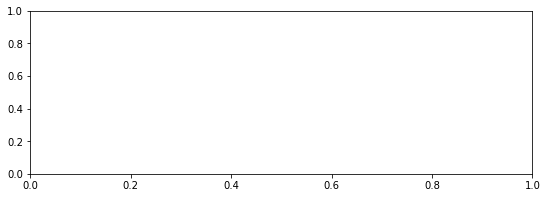

In [120]:
x, y, u, v, p, T, U = [], [], [], [], [], [], []
fig, ax = plt.subplots(figsize=(9, 3))
time = 95
for i in range(0, len(ds[time].elem)):
    pt_x = np.nanmean(ds[time].elem[i].pos[0, 0], axis=(1))[0]
    pt_y = np.nanmean(ds[time].elem[i].pos[1, 0], axis=(1))[0]
    pt_u = np.nanmean(ds[time].elem[i].vel[0, 0], axis=(1))[0]
    pt_v = np.nanmean(ds[time].elem[i].vel[1, 0], axis=(1))[0]
    pt_p = np.nanmean(ds[time].elem[i].pres[0, 0], axis=(1))[0]
    pt_T = np.nanmean(ds[time].elem[i].temp[0, 0], axis=(1))[0]
    pt_U = np.sqrt(pt_u**2 + pt_v**2)
    x.append(pt_x)
    y.append(pt_y)
    u.append(pt_u)
    v.append(pt_v)
    p.append(pt_p)
    U.append(pt_U)
    T.append(pt_T)
    # ax.annotate(str(i), xy=(pt_x, pt_y))
    
# Interpolation
# im = ax.tricontourf(x, y, T, 16, cmap='RdBu_r')
X, Y = np.meshgrid(x, y)
ax.pcolormesh(X, Y, np.array(T).reshape(len(x), len(y)))
# im = ax.quiver(x, y, u, v, U)
ax.set_title('time = {0:.2f}'.format(ds[time].time))
ax.set_xlim([min(x), max(x)])
ax.set_ylim([min(y), max(y)])
ax.set_aspect('equal')
fig.colorbar(im)

#### Mesh troubleshooting

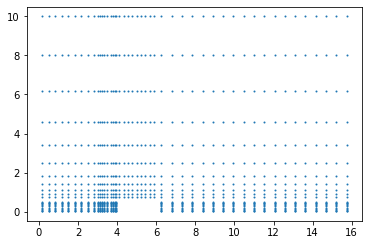

In [111]:
re2 = pymech.neksuite.readre2('/Users/gabriel/Nek5000/run/int_bdy/int_bdy.re2')
re2
pt_x, pt_y = [], []
for i in range(0, len(re2.elem)):
    pt_x.append(np.nanmean(re2.elem[i].pos[0, 0, 1]))
    pt_y.append(np.nanmean(re2.elem[i].pos[1, 0, 1]))
fig, ax = plt.subplots()
ax.scatter(pt_x, pt_y, s=1)
ax.set_aspect('equal')

#### Flow profile definition

In [21]:
ds

[<pymech.exadata.exadata>
 Dimensions:    2
 Precision:     4 bytes
 Mesh limits:
   * x:         [0. 3.]
   * y:         [0. 1.]
   * z:         [0. 0.]
 Time:
   * time:      0.01
   * istep:     100
 Elements:
   * nel:       500
   * elem:      [<elem centered at [0.1   0.025 0.   ]>
                 ...
                 <elem centered at [2.97500002 0.97499999 0.        ]>],
 <pymech.exadata.exadata>
 Dimensions:    2
 Precision:     4 bytes
 Mesh limits:
   * x:         [0. 3.]
   * y:         [0. 1.]
   * z:         [0. 0.]
 Time:
   * time:      0.02
   * istep:     200
 Elements:
   * nel:       500
   * elem:      [<elem centered at [0.1   0.025 0.   ]>
                 ...
                 <elem centered at [2.97500002 0.97499999 0.        ]>],
 <pymech.exadata.exadata>
 Dimensions:    2
 Precision:     4 bytes
 Mesh limits:
   * x:         [0. 3.]
   * y:         [0. 1.]
   * z:         [0. 0.]
 Time:
   * time:      0.03
   * istep:     300
 Elements:
   * nel:       500
 

(0.0, 1.0)

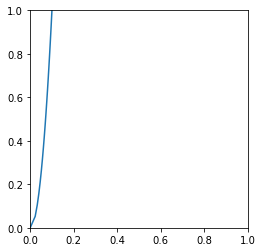

In [15]:
H = 1
U = 0.1
d, z_0 = 0, 0.1
k = 0.4
ys = np.linspace(0, H, 20)
u = [U*np.sqrt(y) for y in ys]

fig, ax = plt.subplots()
ax.plot(u, ys)
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])